# Click Through Rate Custom Classifier



## Introduction

In the online advertising industry, correctly predicting whether an impression will lead to a conversion can lead to massive profits. In online advertising vernacular, an impression is the viewing of the advertisement. We define a conversion as a click in this project, but a conversion could also refer to a purchase or call to action. The advertisement is usually a combination of pictures, video, or text, known as a “creative advertisement”. Google alone serves an average of almost 30 billion impressions per day, meaning that a minuscule improvement in predicting click through rate can create billions of revenue for the company over a year. The methods presented in this paper aim to develop a flexible and robust click through rate prediction algorithm based on user data. Time series features pertaining to a data set of impressions on an eCommerce site with 40 million impressions are collected and assigned to two classes (conversion or no conversion) using logistic regression. The Precision Recall Threshold is then adjusted to find the optimal bidding strategy.

## Methodology

We will use Sci-kit Learn’s implementation of a Logistic Regression to classify our data into clicks or no clicks. Next, we create a Grid Search to tune our hyperparameters and find the model with the highest precision. Then we will find the best decision threshold using the precision-recall curve and the ROC curve. Finally, we will present our results and conclusions
Our data contains 10 days of impression data from Avazu, an Advertising Technology (AdTech) company dealing with Real-Time Bidding (RTB). We sample approximately 10% of this data randomly for all modelling purposes. In particular for each hourly interval we ensure that there is a there is at least 1 impression.
Next, we check the value counts to confirm that sampling did not alter the imbalance of the classes. 83% of the impressions resulted in no-click, whereas 17% resulted in a click.


## Performance Metrics

Due to the nature of click through rate prediction, accuracy is not a good metric for measuring our model. We want to put a higher focus on correctly predicting that impressions lead to conversions. One could build a model that achieves high accuracy scores by correctly predicting no clicks, but with poor performance when predicting clicks. That model would not be very valuable in a click through rate prediction environment because it does not deliver value. 
Predicting Click Through Rate(CTR) is problematic for companies because of the unbalanced distribution between clicks and no-clicks. There is also a lot of noise in the data and a small amount of conversions. Companies can usually transform around 0.05% of total impressions into conversions. The dataset being used in this project has upsampled the conversion rate to 17%. 
We will use a confusion matrix and focus on precision score as our metric for model performance. A confusion matrix shows us how our model performance compares to the ground truth. The precision score is the number of true positives divided by the number of predicted positives (true positives + false positives). 
 
Suppose a model designed to predict click through rate predicts 8 clicks in a day that had a total of 12 clicks and some no clicks. Of the 8 predicted clicks, 5 are actually clicks, or true positives, while the rest are no clicks, or false positives. The model’s precision is 5/8  or 0.625. The recall is 5/12, or .42. In this case, the precision tells us how accurate the model can correctly predict a click among actual clicks. The recall tells us how well our model can find all the correct clicks.


### Imports

In [0]:
import random
import pandas as pd
import numpy as np
from sklearn.metrics import *

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier


from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt


In [0]:
''' Sample from Training Data down to 1 million records'''

n = 40428966  #total number of records in the dataset 
sample_size = 1000000
skiprows = sorted(random.sample(range(1,n-1), n-sample_size)) 



In [0]:
'''import the dataframe with skipped rows, since it is in .gz format we must add a parameter for compression'''
ctr_data = pd.read_csv('https://bidtime.s3.amazonaws.com/Avazu/train/train.gz', skiprows=skiprows, compression='infer')

In [0]:
'''Click through rate is an inbalanced class problem, because the majority of impressions do not lead to a conversion
We can verify this by looking at the value counts. We see that this dataset has about 17% clicks
In the real world, that would be an amazing CTR, so we can assume this data has been upsampled'''
ctr_data.click.value_counts()

0    829946
1    170055
Name: click, dtype: int64

## Time and Weekday Analysis

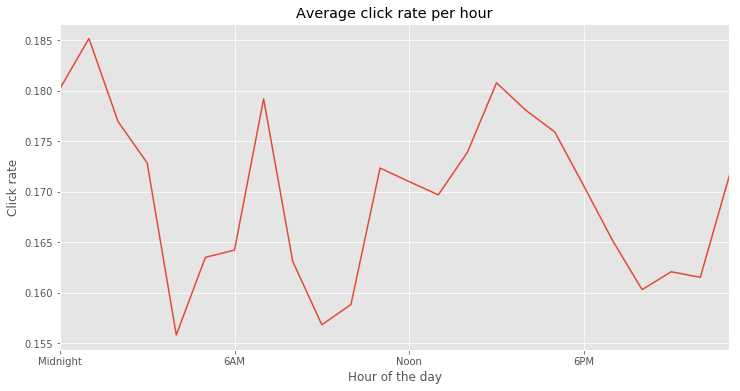

In [0]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['hour'])['click'].mean())
plt.xlabel("Hour of the day")
plt.ylabel("Click rate")
plt.title("Average click rate per hour")
plt.xticks(np.arange(0, 23, step=6), ('Midnight', '6AM', 'Noon', '6PM'))
plt.xlim([0.0, 23.0])
plt.show()

Users click on ads the most around 1 AM, 7AM, and 3PM.
They click on ads the least around 4AM, 9AM, and 8 PM.

This suggests that the best time to run ads for maximum impressions is just after midnight, but not too late, early in the morning but before the work commute begins, and in the afternoon. This maps well with when workers are least prodcutive at work, the afternoon. During the evening users may be engaging in activities outside of a screen, but later at night they are back on the internet.

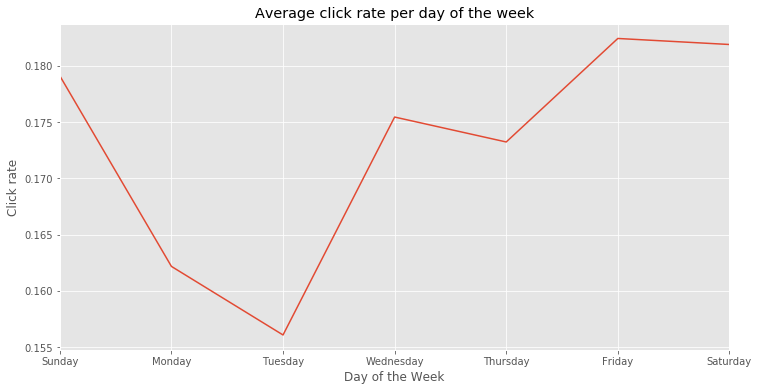

In [0]:
plt.figure(figsize=(12,6))
plt.plot(df.groupby(df['weekday'])['click'].mean())
plt.xlabel("Day of the Week")
plt.xticks(np.arange(0, 7, step=1), ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',))
plt.xlim([0.0, 6.0])
plt.ylabel("Click rate")
plt.title("Average click rate per day of the week")
plt.show()

Users click on ads the most on the weekend, which suggests that when users have free time, they are spending it online. Tuesday and Monday are the worst days for ads, and as we get closer to the weekend, click rates improve.

### Target and Feature Encoding

No-click impressions are represented as 0, and clicks are represented as 1.
We took the first 100,000 impressions (which accounts for 10% of the data), to generate a historical CTR measurement. We use this as a feature for all future predictions. We exclude this data for the rest of this experiment.
The historical CTR, per feature were then inserted into the remaining 90% of the data, and then split again for training and testing. Intuitively, this makes sense, the best predictor for how an advertisement will perform in the future, is how similar ads performed in the past. 
Also, we will drop features from our model that we do not expect to have predictive power, and create a train-test split.


In [0]:
'''By default the majority class (0-No Click) will be negative'''
lb = LabelBinarizer()
ctr_data['click'] = lb.fit_transform(ctr_data['click'].values)
targets = ctr_data['click']


In [0]:
'''We can also drop a few features that will not improve the model'''
ctr_data.drop(['click', 'id', 'device_id', 'device_ip'], axis=1, inplace=True)

In [0]:
'''Create test train split'''
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ctr_data, targets, test_size=0.1, random_state=42, shuffle=False)

In [0]:
'''Encode data with One hot encoder'''
enc = OneHotEncoder(handle_unknown='ignore')
X_train = enc.fit_transform(X_train)
X_test = enc.transform(X_test)

## Model

For our model we use a Logistic Regression with parameters obtained via Stochastic Gradient Descent (SGD). We use Logistic Regression because the results are easy to interpret and the computational load is low. This estimator implements regularized General Linear Models (GLM) with SGD. This is an online learning model that will help us reduce compute time. SGD sequentially updates the model parameters via Gradient Descent, with batched training samples one at a time, instead of the entire training set at once, saving computational power. To get our batches, we continuously sample from m observations, which we compute the gradient from. A click through rate prediction model must include the most recent user behavior and trends. The gradient of the loss is estimated at each SGD iteration.
We create our hyperparameter grid and our metrics. The hyperparameter that we focused on the most was, the initial learning rate value. Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our model with respect the loss gradient. The lower the value, the slower we travel along the slope of opposite of the error function. While using a small learning rate might be effective at ensuring local minimas are not missed, it could also mean that it can take a long time for the parameter values to converge . 
Our model uses five metrics, the precision recall curve covers the precision and recall metrics. Next we have the accuracy and the ROC of AUC score.  The accuracy will simply look at how many predictions were correct, while the ROC scorer will look at the true positive rate versus the false positive rate. Finally, we will score our model on a custom metric (specified in the Grid Search Wrapper Section), based on the results of the previous models. 

In [0]:
clf = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10, learning_rate='constant', eta0=0.01)

'''
Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our model 
with respect the loss gradient. The lower the value, the slower we travel along the slope of opposite
of the error function. While using a small learning rate might be effective at ensuring local minimas
are not missed, it could also mean that it can take a long time for the parameter values to converge. 
'''
param_grid = {
 'eta0': [0.165, 0.17, 0.175, .18]   
}

metrics = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

## Grid Search Wrapper


This Grid Search Wrapper function uses GridSearchCV to fit our Logistic Regression model using different metrics specified in the paramater grid. The scores are saves and the best performing model is used for the full training dataset. refit_score for optimization and prints the accompanying confusion matrix. In this case, we want to refit_score based on the metrics we created to optimize our model. 

The scores from metrics are recorded and the best model will be selected and "refit" to the full training data. This function also makes predictions on the held out X_test and prints the confusion matrix to show performance. The function allows us to easily fit the model according to the metric chosen.

## Stratified K Fold


K fold is a cross validation technique that divides the dataset into k groups of similar size. One fold is held out for testing and the other folds are used for training. The process is then repeated k times and each time a different fold is used for testing. While K fold is relatively computationally intensive as the model has to be rerun from scratch several times, it offers it’s advantages to our use case. K fold can reduce bias because it randomizes the data into different arrangements of training and validation segments (folds).
In our work, we stratified the data, such that in each fold the percentage of Clicks and No Clicks was similar. We do this to reduce class imbalance such that no single fold of data has an over or under representation which can impact our model training negatively.


In [0]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    This function fits a GridSearchCV classifier using refit_score for 
    optimization and prints the classifier's confusion matrix
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=metrics, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['predicted_no_click', 'preditced_click'], index=['No click', 'Click']))
    return grid_search

In [0]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{'eta0': 0.165}

Confusion matrix of Random Forest optimized for precision_score on the test data:
          predicted_no_click  preditced_click
No click               73532             9673
Click                  11637             5159


In [0]:
#compare the results of the different learning rates
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_eta0'
         ]].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_eta0
0,0.242138,0.255821,0.694063,0.165
2,0.241975,0.205430,0.713131,0.175
3,0.235003,0.241722,0.704880,0.18
1,0.223830,0.197796,0.715857,0.17


In [0]:
#Earlier we had our best eta0 at .165, but when we optimize for recall score
#the best eta0 is .17. 
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'eta0': 0.17}

Confusion matrix of Random Forest optimized for recall_score on the test data:
          predicted_no_click  preditced_click
No click               76012             7193
Click                  13544             3252


In [0]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
        ]].head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score
1,0.219989,0.290039,0.682690
3,0.198636,0.225422,0.699949
0,0.217006,0.206879,0.713864
2,0.216372,0.204333,0.708243


In [0]:
#Make our predictions
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

In [0]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    """
    return [1 if y >= t else 0 for y in y_scores]

In [0]:
#Define precision, recall and thresholds
p, r, thresholds = precision_recall_curve(y_test, y_scores)


In [0]:
def precision_recall_threshold(t=0.5):
    """
    This function plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['predicted_no_click', 'preditced_click'],
                       index=['No click', 'Click']))

## Precision Recall Threshold

With reference to confusion matrices below, as we increase the decision threshold, we also generate increasingly conservative predictions. As a result, more cases the prediction is a negative (no-click).


By changing the precision recall threshold of our model, we can specifically alter how many clicks or no clicks we predict. This allows us to deliver a robust model that is able to adapt to the company’s needs. By tweaking the decision threshold of your model and using historical rates, the company can dramatically change the amount of impressions that are converted into clicks when used in combination with an appropriate bidding strategy.


In [0]:
precision_recall_threshold(0.001)

          predicted_no_click  preditced_click
No click                1497            81708
Click                     32            16764


In [0]:
precision_recall_threshold(0.1)

          predicted_no_click  preditced_click
No click               42547            40658
Click                   4125            12671


In [0]:
precision_recall_threshold(0.2)

          predicted_no_click  preditced_click
No click               55386            27819
Click                   7115             9681


In [0]:
precision_recall_threshold(0.3)

          predicted_no_click  preditced_click
No click               64878            18327
Click                  10008             6788


In [0]:
precision_recall_threshold(0.4)

          predicted_no_click  preditced_click
No click               71275            11930
Click                  12005             4791


In [0]:
precision_recall_threshold(.990)

          predicted_no_click  preditced_click
No click               83204                1
Click                  16788                8


## Results

Below we have the Precision and Recall Scores as a function of the decision threshold. This plot shows the relationship between recall and precision as we change the Decision Threshold

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    This function will allow us to plot the precision vs the recall as a result of the PRT.
    As you can see they converge around .2, the number we chose for our bidding strategy.
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

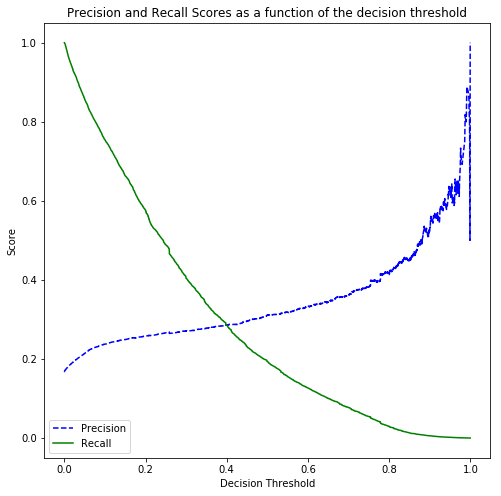

In [0]:
plot_precision_recall_vs_threshold(p, r, thresholds)


In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    This function allows us to plot the ROC Curve
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

Average ROC: 0.6702583084165381


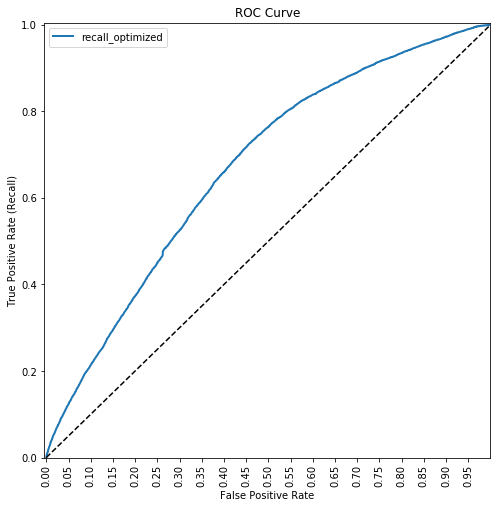

In [0]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_scores)
print('Average ROC:',auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')